In [110]:
# import packages

import gc
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format # disabling scientific notation in pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import lightgbm as lgb
import optuna

gc.enable()

In [2]:
X_train = pd.read_csv("data/X_train.csv", index_col=0) 
y_train = pd.read_csv("data/y_train.csv", index_col=0) 


In [18]:
non_cat = ['visitNumber', 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'device_isMobile', 'date_dow', 'date_hours', 'date_dom', 'month', 'days_since_visit']

In [19]:
cat_vars = [c for c in X_train.columns if c not in non_cat]

In [14]:
X_train.columns

Index(['channelGrouping', 'visitNumber', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'date_dow', 'date_hours', 'date_dom', 'month',
       'days_since_visit', 'source_country', 'campaign_medium',
       'browser_category', 'browser_os',
       'device_deviceCategory_channelGrouping', 'channelGrouping_browser',
       'channelGroupi

In [315]:
from sklearn.metrics import fbeta_score, accuracy_score#, recall_score, roc_auc_score, pr

def lgb_f2_score(y_true, y_pred):
    
    y_pred = np.round(y_pred) # scikits fbeta doesn't like probabilities as they are continuous
    #print(y_true)
    #print(y_pred)
    return 'f2', fbeta_score(y_true, y_pred, beta=2), True #https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier.fit

In [81]:
train_x, eval_x, train_y, eval_y = train_test_split(X_train, y_train, test_size=0.1)

clf = lgb.LGBMClassifier(objective="binary", n_estimators=1000)
eval_set = [(eval_x, eval_y)]

In [82]:
clf.fit(
    train_x,
    train_y,
    eval_set=eval_set,
    early_stopping_rounds=300,
    eval_metric=lgb_f2_score,
)

/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. 

[1]	valid_0's binary_logloss: 0.0456339	valid_0's f2: 0.0786211
[2]	valid_0's binary_logloss: 0.0431875	valid_0's f2: 0.0786211
[3]	valid_0's binary_logloss: 0.0413935	valid_0's f2: 0.0785973
[4]	valid_0's binary_logloss: 0.0399604	valid_0's f2: 0.081448
[5]	valid_0's binary_logloss: 0.0386895	valid_0's f2: 0.0945662
[6]	valid_0's binary_logloss: 0.0376287	valid_0's f2: 0.11742
[7]	valid_0's binary_logloss: 0.036702	valid_0's f2: 0.130101
[8]	valid_0's binary_logloss: 0.0358969	valid_0's f2: 0.13852
[9]	valid_0's binary_logloss: 0.0352182	valid_0's f2: 0.149341
[10]	valid_0's binary_logloss: 0.0346191	valid_0's f2: 0.175464
[11]	valid_0's binary_logloss: 0.0340844	valid_0's f2: 0.181766
[12]	valid_0's binary_logloss: 0.0335962	valid_0's f2: 0.187158
[13]	valid_0's binary_logloss: 0.0331782	valid_0's f2: 0.192253
[14]	valid_0's binary_logloss: 0.0327448	valid_0's f2: 0.196219
[15]	valid_0's binary_logloss: 0.0323933	valid_0's f2: 0.197425
[16]	valid_0's binary_logloss: 0.0320787	valid_0

LGBMClassifier(n_estimators=1000, objective='binary')

In [83]:
X_test = pd.read_csv("data/X_test.csv", index_col=0) 
y_test = pd.read_csv("data/y_test.csv", index_col=0) 

In [84]:
test_pred = clf.predict(X_test)

In [86]:
fbeta_score(y_test, test_pred, beta=2)

0.2807051159225905

In [416]:
accuracy_score(y_test, test_pred), recall_score(y_test, test_pred), precision_score(y_test, test_pred)

(0.9875492473054754, 0.25049871758335707, 0.5422578655151141)

In [104]:
importances_df = pd.DataFrame()
importances_df['feature'] = X_train.columns
importances_df['gain'] = clf.booster_.feature_importance(importance_type='gain')
importances_df['split'] = clf.booster_.feature_importance(importance_type='split')

In [106]:
importances_df['gain_log'] = np.log1p(importances_df['gain'])
importances_df['split_log'] = np.log1p(importances_df['split'])

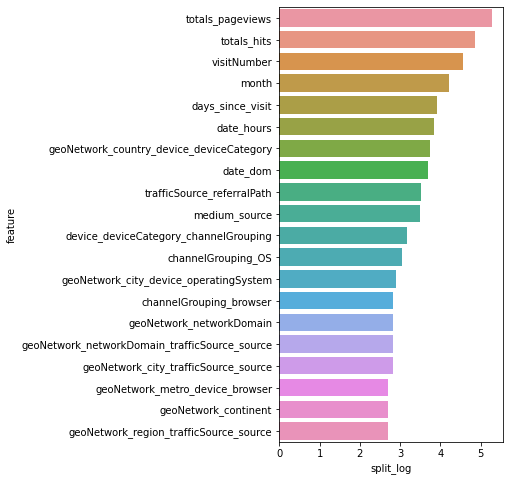

In [408]:
plt.figure(figsize=(4, 8))
sns.barplot(x='split_log', y='feature', data=importances_df.sort_values('split_log', ascending=False).head(20))

# save the plot as a PNG file
plt.savefig('feature_importance_split_lgbm_oob_top20.png', dpi=300, bbox_inches='tight')

# show the plot
plt.show()

In [108]:
importances_df

,feature,gain,split,gain_log,split_log
0,channelGrouping,"1,122.71",7,7.02,2.08
1,visitNumber,"15,551.77",95,9.65,4.56
2,totals_bounces,0.00,0,0.00,0.00
3,totals_hits,"6,491.16",127,8.78,4.85
4,totals_newVisits,19.13,1,3.00,0.69
...,...,...,...,...,...
64,geoNetwork_subContinent_device_deviceCategory,190.93,4,5.26,1.61
65,geoNetwork_subContinent_device_operatingSystem,116.29,4,4.76,1.61
66,geoNetwork_subContinent_trafficSource_source,253.25,6,5.54,1.95
67,content_source,26.57,2,3.32,1.10


In [154]:
from optuna.integration import LightGBMPruningCallback
import warnings
warnings.simplefilter('ignore')

In [164]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11212184)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        train_x, test_x = X.iloc[train_idx], X.iloc[test_idx]
        train_y, test_y = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            train_x,
            train_y,
            eval_set=[(test_x, test_y)],
            eval_metric=lgb_f2_score,
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, 'f2') 
            ],  # Add a pruning callback
        )
        preds = model.predict(test_x)
        cv_scores[idx] = fbeta_score(test_y, preds,beta=2)

    return np.mean(cv_scores)

In [165]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train.to_numpy().ravel()) ## does not like dataframes as ys / could it be that indexes fuck up performance?
study.optimize(func, n_trials=100)

[I 2023-02-05 11:14:01,154] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=9.353976608109104, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.353976608109104
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is 

[I 2023-02-05 11:19:25,397] Trial 0 finished with value: 0.206034986694223 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2800427454907056, 'num_leaves': 2680, 'max_depth': 3, 'min_data_in_leaf': 800, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 9.353976608109104, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.206034986694223.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.984761520757047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.984761520757047
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction i

[I 2023-02-05 11:22:29,929] Trial 1 finished with value: 0.13799773027517787 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23023002443887028, 'num_leaves': 540, 'max_depth': 12, 'min_data_in_leaf': 4200, 'lambda_l1': 95, 'lambda_l2': 70, 'min_gain_to_split': 7.984761520757047, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.206034986694223.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.792975339860934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.792975339860934
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction

[I 2023-02-05 11:26:48,689] Trial 2 finished with value: 0.12939093059747422 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26747785325714685, 'num_leaves': 660, 'max_depth': 7, 'min_data_in_leaf': 8700, 'lambda_l1': 80, 'lambda_l2': 55, 'min_gain_to_split': 10.792975339860934, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.206034986694223.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=5.435762279507202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.435762279507202
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will 

[I 2023-02-05 11:34:01,611] Trial 3 finished with value: 0.12632866050507677 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10138363364546689, 'num_leaves': 1500, 'max_depth': 7, 'min_data_in_leaf': 8000, 'lambda_l1': 80, 'lambda_l2': 65, 'min_gain_to_split': 5.435762279507202, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.206034986694223.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.851642596346377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.851642596346377
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction i

[I 2023-02-05 11:37:47,868] Trial 4 finished with value: 0.20243543495445407 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14679183041851998, 'num_leaves': 1260, 'max_depth': 9, 'min_data_in_leaf': 1100, 'lambda_l1': 60, 'lambda_l2': 5, 'min_gain_to_split': 11.851642596346377, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.206034986694223.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.188419808437841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.188419808437841
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:37:58,733] Trial 5 pruned. Trial was pruned at iteration 9.
[I 2023-02-05 11:38:08,573] Trial 6 pruned. Trial was pruned at iteration 9.
[I 2023-02-05 11:38:16,646] Trial 7 pruned. Trial was pruned at iteration 9.
[I 2023-02-05 11:38:26,491] Trial 8 pruned. Trial was pruned at iteration 16.
[I 2023-02-05 11:38:32,478] Trial 9 pruned. Trial was pruned at iteration 9.
[I 2023-02-05 11:38:40,976] Trial 10 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=14.805565713370795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.805565713370795
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction i

[I 2023-02-05 11:40:40,198] Trial 11 finished with value: 0.40674110677241454 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1678067142404052, 'num_leaves': 2940, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 20, 'lambda_l2': 0, 'min_gain_to_split': 14.805565713370795, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.40674110677241454.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=14.505670821678358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.505670821678358
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:40:46,539] Trial 12 pruned. Trial was pruned at iteration 4.
[I 2023-02-05 11:40:53,695] Trial 13 pruned. Trial was pruned at iteration 4.
[I 2023-02-05 11:41:03,639] Trial 14 pruned. Trial was pruned at iteration 4.
[I 2023-02-05 11:41:08,765] Trial 15 pruned. Trial was pruned at iteration 4.
[I 2023-02-05 11:41:16,189] Trial 16 pruned. Trial was pruned at iteration 4.
[I 2023-02-05 11:41:24,190] Trial 17 pruned. Trial was pruned at iteration 4.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=13.284168802081647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.284168802081647
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[I 2023-02-05 11:43:27,793] Trial 18 finished with value: 0.3903751668412085 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2963316993184939, 'num_leaves': 2620, 'max_depth': 3, 'min_data_in_leaf': 2700, 'lambda_l1': 35, 'lambda_l2': 0, 'min_gain_to_split': 13.284168802081647, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 11 with value: 0.40674110677241454.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=13.457782188844181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.457782188844181
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction

[I 2023-02-05 11:45:29,461] Trial 19 finished with value: 0.3984662535911818 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15912434121295513, 'num_leaves': 1120, 'max_depth': 6, 'min_data_in_leaf': 2700, 'lambda_l1': 40, 'lambda_l2': 0, 'min_gain_to_split': 13.457782188844181, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 11 with value: 0.40674110677241454.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=14.815649269616696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.815649269616696
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:45:34,092] Trial 20 pruned. Trial was pruned at iteration 1.
[I 2023-02-05 11:45:38,762] Trial 21 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=13.51917936166962, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.51917936166962
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 11:47:39,905] Trial 22 finished with value: 0.4556356529033529 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2106824320775506, 'num_leaves': 180, 'max_depth': 4, 'min_data_in_leaf': 5200, 'lambda_l1': 35, 'lambda_l2': 10, 'min_gain_to_split': 13.51917936166962, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 22 with value: 0.4556356529033529.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=11.435850296830619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.435850296830619
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:47:44,705] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=13.706690769399401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.706690769399401
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-02-05 11:50:00,217] Trial 24 finished with value: 0.44685784252779304 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20980476521984545, 'num_leaves': 20, 'max_depth': 8, 'min_data_in_leaf': 4900, 'lambda_l1': 10, 'lambda_l2': 10, 'min_gain_to_split': 13.706690769399401, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 22 with value: 0.4556356529033529.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=11.828166416367694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.828166416367694
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:50:06,358] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 11:50:10,851] Trial 26 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=14.96985343663284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.96985343663284
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 11:52:20,285] Trial 27 finished with value: 0.46421596754032796 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2465988541197333, 'num_leaves': 340, 'max_depth': 8, 'min_data_in_leaf': 6900, 'lambda_l1': 20, 'lambda_l2': 20, 'min_gain_to_split': 14.96985343663284, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 27 with value: 0.46421596754032796.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.425675692334995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.425675692334995
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be

[I 2023-02-05 11:54:15,464] Trial 28 finished with value: 0.4706916392195927 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2507581235788208, 'num_leaves': 300, 'max_depth': 8, 'min_data_in_leaf': 6800, 'lambda_l1': 0, 'lambda_l2': 20, 'min_gain_to_split': 12.425675692334995, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 28 with value: 0.4706916392195927.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.6951911493743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.6951911493743
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:54:20,541] Trial 29 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.30899370894091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.30899370894091
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 11:56:04,840] Trial 30 finished with value: 0.46421596754032796 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2617174209103109, 'num_leaves': 340, 'max_depth': 11, 'min_data_in_leaf': 6800, 'lambda_l1': 20, 'lambda_l2': 20, 'min_gain_to_split': 12.30899370894091, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 28 with value: 0.4706916392195927.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=12.451879278915149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.451879278915149
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 wil

[I 2023-02-05 11:57:50,806] Trial 31 finished with value: 0.45076103890199004 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2621905573066927, 'num_leaves': 380, 'max_depth': 12, 'min_data_in_leaf': 6700, 'lambda_l1': 20, 'lambda_l2': 20, 'min_gain_to_split': 12.451879278915149, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 28 with value: 0.4706916392195927.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=11.010237651719018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.010237651719018
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 11:57:56,220] Trial 32 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=12.434800451725964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.434800451725964
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-02-05 11:59:46,962] Trial 33 finished with value: 0.5451123663790891 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2607643223046681, 'num_leaves': 240, 'max_depth': 11, 'min_data_in_leaf': 5600, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 12.434800451725964, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=9.285797539218567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.285797539218567
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 12:01:33,634] Trial 34 finished with value: 0.5191579199683946 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2766188450565121, 'num_leaves': 460, 'max_depth': 11, 'min_data_in_leaf': 8100, 'lambda_l1': 10, 'lambda_l2': 30, 'min_gain_to_split': 9.285797539218567, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.869769264820919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.869769264820919
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:01:37,805] Trial 35 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.057724805254159, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.057724805254159
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[I 2023-02-05 12:03:25,798] Trial 36 finished with value: 0.5001546390250582 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2834456409070413, 'num_leaves': 520, 'max_depth': 12, 'min_data_in_leaf': 7700, 'lambda_l1': 0, 'lambda_l2': 30, 'min_gain_to_split': 9.057724805254159, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.306675872644096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.306675872644096
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[I 2023-02-05 12:05:14,365] Trial 37 finished with value: 0.5201254157646451 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28428416311394455, 'num_leaves': 500, 'max_depth': 12, 'min_data_in_leaf': 9200, 'lambda_l1': 0, 'lambda_l2': 35, 'min_gain_to_split': 8.306675872644096, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=9.289638776499624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.289638776499624
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[I 2023-02-05 12:07:01,132] Trial 38 finished with value: 0.5201254157646451 and parameters: {'n_estimators': 10000, 'learning_rate': 0.299280756832675, 'num_leaves': 560, 'max_depth': 12, 'min_data_in_leaf': 9600, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 9.289638776499624, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.17547469663397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.17547469663397
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be

[I 2023-02-05 12:08:48,215] Trial 39 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2965579097049783, 'num_leaves': 620, 'max_depth': 11, 'min_data_in_leaf': 9800, 'lambda_l1': 95, 'lambda_l2': 45, 'min_gain_to_split': 8.17547469663397, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.43178611786898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.43178611786898
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:08:52,373] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:08:56,788] Trial 41 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:09:00,627] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:09:04,580] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:09:09,449] Trial 44 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.731838552558592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.731838552558592
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[I 2023-02-05 12:11:01,731] Trial 45 finished with value: 0.5201254157646451 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28856349534361686, 'num_leaves': 1380, 'max_depth': 10, 'min_data_in_leaf': 8800, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 8.731838552558592, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.945052326943984, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.945052326943984
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be i

[I 2023-02-05 12:12:48,861] Trial 46 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2996025333693379, 'num_leaves': 1700, 'max_depth': 10, 'min_data_in_leaf': 8800, 'lambda_l1': 5, 'lambda_l2': 50, 'min_gain_to_split': 6.945052326943984, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.519326465061216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.519326465061216
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:14:32,091] Trial 47 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2999854706578676, 'num_leaves': 1820, 'max_depth': 12, 'min_data_in_leaf': 9400, 'lambda_l1': 50, 'lambda_l2': 50, 'min_gain_to_split': 6.519326465061216, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.090657920296561, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.090657920296561
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:14:36,085] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:14:40,983] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:14:46,315] Trial 50 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.2873280939993546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.2873280939993546
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-02-05 12:16:37,526] Trial 51 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2970800392834333, 'num_leaves': 1720, 'max_depth': 12, 'min_data_in_leaf': 9500, 'lambda_l1': 15, 'lambda_l2': 45, 'min_gain_to_split': 6.2873280939993546, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.661627419465672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.661627419465672
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:18:28,173] Trial 52 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29941314606430064, 'num_leaves': 2160, 'max_depth': 11, 'min_data_in_leaf': 9500, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 5.661627419465672, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=5.435050810811211, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.435050810811211
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:18:32,683] Trial 53 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.534978117754769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.534978117754769
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:20:21,428] Trial 54 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2906757534271671, 'num_leaves': 1740, 'max_depth': 10, 'min_data_in_leaf': 8500, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 5.534978117754769, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=6.412629437327959, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.412629437327959
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:20:25,831] Trial 55 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=4.878247043397171, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.878247043397171
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:22:14,538] Trial 56 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29986971363378956, 'num_leaves': 1440, 'max_depth': 12, 'min_data_in_leaf': 9600, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 4.878247043397171, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.254355805290956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.254355805290956
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:22:18,931] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:22:22,673] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:22:26,822] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:22:31,888] Trial 60 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.1594511948209405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.1594511948209405
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-02-05 12:24:25,647] Trial 61 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2925914628425756, 'num_leaves': 1800, 'max_depth': 11, 'min_data_in_leaf': 8500, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 6.1594511948209405, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.7160488167300025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.7160488167300025
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:24:29,823] Trial 62 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.212720692282027, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.212720692282027
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 12:26:31,438] Trial 63 finished with value: 0.5287997274354426 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29961493098726055, 'num_leaves': 1980, 'max_depth': 12, 'min_data_in_leaf': 9400, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 7.212720692282027, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.192739906247186, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.192739906247186
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 12:28:22,428] Trial 64 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.299509057426242, 'num_leaves': 1920, 'max_depth': 12, 'min_data_in_leaf': 9400, 'lambda_l1': 55, 'lambda_l2': 45, 'min_gain_to_split': 7.192739906247186, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=6.737240554934376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.737240554934376
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:28:27,225] Trial 65 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.585167753802156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.585167753802156
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:30:35,525] Trial 66 finished with value: 0.5272132579126269 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2680729001598051, 'num_leaves': 1600, 'max_depth': 12, 'min_data_in_leaf': 8900, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 7.585167753802156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=7.872458114256592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.872458114256592
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3800
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:30:41,153] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:30:47,730] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:30:52,352] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:31:00,246] Trial 70 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.553987830929779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.553987830929779
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:33:13,628] Trial 71 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29070375387244535, 'num_leaves': 1800, 'max_depth': 9, 'min_data_in_leaf': 8400, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 5.553987830929779, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.977265738898328, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.977265738898328
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:35:10,525] Trial 72 finished with value: 0.5277717634553143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2798731751755017, 'num_leaves': 1680, 'max_depth': 10, 'min_data_in_leaf': 9000, 'lambda_l1': 30, 'lambda_l2': 50, 'min_gain_to_split': 5.977265738898328, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.2063332502501485, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.2063332502501485
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 wil

[I 2023-02-05 12:37:13,121] Trial 73 finished with value: 0.5274534630239381 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29217078069674124, 'num_leaves': 1480, 'max_depth': 11, 'min_data_in_leaf': 8000, 'lambda_l1': 20, 'lambda_l2': 40, 'min_gain_to_split': 5.2063332502501485, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.349901523248331, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.349901523248331
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:37:17,991] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2023-02-05 12:37:24,217] Trial 75 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=5.722231219258867, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.722231219258867
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will 

[I 2023-02-05 12:39:15,057] Trial 76 finished with value: 0.5554429830845798 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29949234220582965, 'num_leaves': 1140, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 45, 'lambda_l2': 50, 'min_gain_to_split': 5.722231219258867, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=6.711918484644375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.711918484644375
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:39:19,104] Trial 77 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=6.025703597904879, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.025703597904879
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 12:41:05,911] Trial 78 finished with value: 0.5554279072161915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29934308619480454, 'num_leaves': 1100, 'max_depth': 12, 'min_data_in_leaf': 2200, 'lambda_l1': 60, 'lambda_l2': 45, 'min_gain_to_split': 6.025703597904879, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.602374209803397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.602374209803397
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be

[I 2023-02-05 12:43:24,716] Trial 79 finished with value: 0.4792304120697718 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28326092344640086, 'num_leaves': 1040, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 60, 'lambda_l2': 45, 'min_gain_to_split': 8.602374209803397, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.1979378344101645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.1979378344101645
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 wil

[I 2023-02-05 12:45:11,102] Trial 80 finished with value: 0.5527620809951447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2659737091892238, 'num_leaves': 1200, 'max_depth': 12, 'min_data_in_leaf': 1200, 'lambda_l1': 55, 'lambda_l2': 30, 'min_gain_to_split': 7.1979378344101645, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.012186554786735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.012186554786735
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 12:46:57,847] Trial 81 finished with value: 0.5520426850445623 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29231986697734547, 'num_leaves': 760, 'max_depth': 12, 'min_data_in_leaf': 1400, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 7.012186554786735, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=7.321568458594241, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.321568458594241
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will 

[I 2023-02-05 12:48:56,993] Trial 82 finished with value: 0.5520426850445623 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28441600395191613, 'num_leaves': 1180, 'max_depth': 12, 'min_data_in_leaf': 1400, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 7.321568458594241, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.337703782117573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.337703782117573
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[I 2023-02-05 12:51:07,174] Trial 83 finished with value: 0.5527620809951447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26317735408249515, 'num_leaves': 1000, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 7.337703782117573, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.289140138542795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.289140138542795
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[I 2023-02-05 12:52:58,980] Trial 84 finished with value: 0.5527620809951447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26396157158133143, 'num_leaves': 1020, 'max_depth': 12, 'min_data_in_leaf': 1600, 'lambda_l1': 55, 'lambda_l2': 25, 'min_gain_to_split': 8.289140138542795, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=7.398100290592787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.398100290592787
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2023-02-05 12:53:04,486] Trial 85 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.555410430286981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.555410430286981
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will 

[I 2023-02-05 12:55:12,173] Trial 86 finished with value: 0.5527620809951447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2642302183410722, 'num_leaves': 1200, 'max_depth': 12, 'min_data_in_leaf': 2000, 'lambda_l1': 60, 'lambda_l2': 25, 'min_gain_to_split': 8.555410430286981, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.382272597186649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.382272597186649
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction i

[I 2023-02-05 12:57:15,638] Trial 87 finished with value: 0.5527620809951447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2634369048137022, 'num_leaves': 1140, 'max_depth': 12, 'min_data_in_leaf': 2100, 'lambda_l1': 60, 'lambda_l2': 25, 'min_gain_to_split': 8.382272597186649, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.371462725446547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.371462725446547
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction i

[I 2023-02-05 12:59:30,354] Trial 88 finished with value: 0.5527620809951447 and parameters: {'n_estimators': 10000, 'learning_rate': 0.252548640688611, 'num_leaves': 1200, 'max_depth': 12, 'min_data_in_leaf': 2000, 'lambda_l1': 65, 'lambda_l2': 25, 'min_gain_to_split': 8.371462725446547, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.388588562607351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.388588562607351
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM

[I 2023-02-05 13:03:45,974] Trial 89 finished with value: 0.4791331322073926 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26661957756848204, 'num_leaves': 760, 'max_depth': 12, 'min_data_in_leaf': 2100, 'lambda_l1': 65, 'lambda_l2': 30, 'min_gain_to_split': 8.388588562607351, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 76 with value: 0.5554429830845798.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=8.05982200689552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.05982200689552
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be

[W 2023-02-05 13:05:09,181] Trial 90 failed with parameters: {'n_estimators': 10000, 'learning_rate': 0.2538492986865995, 'num_leaves': 1340, 'max_depth': 12, 'min_data_in_leaf': 1100, 'lambda_l1': 60, 'lambda_l2': 15, 'min_gain_to_split': 8.05982200689552, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3766/395478799.py", line 2, in <lambda>
    func = lambda trial: objective(trial, X_train, y_train.to_numpy().ravel()) ## does not like dataframes as ys
  File "/tmp/ipykernel_3766/1208543086.py", line 28, in objective
    model.fit(
  File "/home/slawa/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weigh

KeyboardInterrupt: 

In [170]:
gc.collect()

743

In [168]:
best_params1 = study.best_params

In [169]:
best_value1 = study.best_trial.value

In [172]:
best_params1,best_value1 

({'n_estimators': 10000,
  'learning_rate': 0.29949234220582965,
  'num_leaves': 1140,
  'max_depth': 12,
  'min_data_in_leaf': 1000,
  'lambda_l1': 45,
  'lambda_l2': 50,
  'min_gain_to_split': 5.722231219258867,
  'bagging_fraction': 0.9,
  'bagging_freq': 1,
  'feature_fraction': 0.9},
 0.5554429830845798)

In [149]:
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

		n_estimators: 10000
		learning_rate: 0.293209130675182
		num_leaves: 2180
		max_depth: 9
		min_data_in_leaf: 3600
		lambda_l1: 0
		lambda_l2: 25
		min_gain_to_split: 3.1647746391081357
		bagging_fraction: 0.4
		bagging_freq: 1
		feature_fraction: 0.8


In [151]:
best_params = study.best_params

In [162]:
best_value = study.best_trial.value

ValueError: No trials are completed yet.

In [173]:
best_params, best_value

({'n_estimators': 10000,
  'learning_rate': 0.293209130675182,
  'num_leaves': 2180,
  'max_depth': 9,
  'min_data_in_leaf': 3600,
  'lambda_l1': 0,
  'lambda_l2': 25,
  'min_gain_to_split': 3.1647746391081357,
  'bagging_fraction': 0.4,
  'bagging_freq': 1,
  'feature_fraction': 0.8},
 0.5502774609810496)

In [163]:
best_value

0.5502774609810496

In [ ]:
Trial 12 finished with value: 0.5502774609810496 and parameters: {'n_estimators': 10000, 'learning_rate': 0.293209130675182, 'num_leaves': 2180, 'max_depth': 9, 'min_data_in_leaf': 3600, 'lambda_l1': 0, 'lambda_l2': 25, 'min_gain_to_split': 3.1647746391081357, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 12 with value: 0.5502774609810496.

In [ ]:
Trial 33 finished with value: 0.5451123663790891 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2607643223046681, 'num_leaves': 240, 'max_depth': 11, 'min_data_in_leaf': 5600, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 12.434800451725964, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 33 with value: 0.5451123663790891.

In [279]:
dart_params = {'n_estimators': 10000, 'learning_rate': 0.019940031689293848, 'num_leaves': 1020, 'max_depth': 9, 'min_data_in_leaf': 7800, 'lambda_l1': 45, 'lambda_l2': 65, 'min_gain_to_split': 1.2991787336282379, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}

Trial 0 finished with value: 0.5703046075913167 and parameters: {'n_estimators': 10000, 'learning_rate': 0.019940031689293848, 'num_leaves': 1020, 'max_depth': 9, 'min_data_in_leaf': 7800, 'lambda_l1': 45, 'lambda_l2': 65, 'min_gain_to_split': 1.2991787336282379, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.5703046075913167.
dart boosting

Try custom loss function with lgb for "objective" parameter.

In the documentation of the LGBMClassifier:

A custom objective function can be provided for the ``objective`` parameter.
In this case, it should have the signature
``objective(y_true, y_pred) -> grad, hess`` or
``objective(y_true, y_pred, group) -> grad, hess``:

    y_true : array-like of shape = [n_samples]
        The target values.
    y_pred : array-like of shape = [n_samples] or shape = [n_samples * n_classes] (for multi-class task)
        The predicted values.
        Predicted values are returned before any transformation,
        e.g. they are raw margin instead of probability of positive class for binary task.
    group : array-like
        Group/query data.
        Only used in the learning-to-rank task.
        sum(group) = n_samples.
        For example, if you have a 100-document dataset with ``group = [10, 20, 40, 10, 10, 10]``, that means that you have 6 groups,
        where the first 10 records are in the first group, records 11-30 are in the second group, records 31-70 are in the third group, etc.
    grad : array-like of shape = [n_samples] or shape = [n_samples * n_classes] (for multi-class task)
        The value of the first order derivative (gradient) of the loss
        with respect to the elements of y_pred for each sample point.
    hess : array-like of shape = [n_samples] or shape = [n_samples * n_classes] (for multi-class task)
        The value of the second order derivative (Hessian) of the loss
        with respect to the elements of y_pred for each sample point.

In [175]:
def f1(y_true, y_pred):
    y_pred = np.round(y_pred)
    tp = np.sum(y_true*y_pred)
    tn = np.sum((1-y_true)*(1-y_pred))
    fp = np.sum((1-y_true)*y_pred)
    fn = np.sum((y_true*(1-y_pred))

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2*p*r / (p+r)
    loss = np.mean(f1)
                
    return K.mean(f1)

In [204]:
from scipy import special

def f1_loss(y_true, y_pred):
    
    y_pred = special.expit(y_pred) # the preds array provided by LightGBM contains raw margin scores instead of probabilities. the preds array provided by LightGBM contains raw margin scores instead of probabilities. 
    #We have thus got to convert them to probabilities ourselves before evaluating the gradient and the Hessian by using a sigmoid transformation. 
    
    tp = np.sum(y_true*y_pred)
    tn = np.sum((1-y_true)*(1-y_pred))
    fp = np.sum((1-y_true)*y_pred)
    fn = np.sum(y_true*(1-y_pred))

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2*p*r / (p+r)

    #loss = 1 - np.mean(f1)
    return 1 - np.mean(f1)

In [205]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
recall_score

In [213]:
def f2_loss(y_true, y_pred):
    
    probs = 1. / (1. + np.exp(-y_pred))
    precision = precision_score(y_true, np.round(probs))
    recall = recall_score(y_true, np.round(probs))
    numerator = 5 * precision * recall
    denominator = 4 * precision + recall + 1e-5
    grad = 5 * (precision * recall) / denominator
    hess = 10 * (precision * recall) / (denominator ** 2)
    return np.array([grad]), np.array([hess])

In [223]:
def soft_f2_loss(y_true, y_pred):
    y_pred = 1. / (1. + np.exp(-y_pred))
    
    epsilon = 1e-15
    
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    y_pred = np.log(y_pred / (1 - y_pred))
    
    tp = np.sum(y_true * y_pred > 0)
    fn = np.sum(y_true > y_pred)
    fp = np.sum(y_pred > y_true)
    
    p = tp / (tp + fp + epsilon)
    r = tp / (tp + fn + epsilon)
    
    f2 = 5 * p * r / (4 * p + r + epsilon)
    
    grad = - (1 - f2) * (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)
    hess = np.zeros_like(y_pred)
    
    return grad, hess


In [247]:
def f2_loss(y_true, y_pred):
    epsilon = 1e-15
    
    y_pred = 1 / (1 + np.exp(-y_pred))
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    tp = np.sum((y_true == 1) & (y_pred > 0.5))
    fn = np.sum((y_true == 1) & (y_pred <= 0.5))
    fp = np.sum((y_true == 0) & (y_pred > 0.5))
    f2 = (5 * tp) / (5 * tp + 4 * fn + fp)
    
    grad = - (1 - f2) * (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)
    hess = (1 - f2) * ((y_pred - y_true) ** 2) / (y_pred * (1 - y_pred) + epsilon)
    
    return grad, hess

In [185]:
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [186]:
test_pred_proba = clf.predict_proba(X_test)

In [228]:
scores = clf.predict_proba(X_test, raw_score=True)

In [231]:
f2_loss(y_test.to_numpy().ravel(), scores)

(array([0.27990682]), array([0.23100807]))

In [241]:
f2_loss(y_test.to_numpy().ravel(), scores)

(array([-0.72013915, -0.72013463, -0.72013463, ..., -0.7223465 ,
        -0.72013148, -0.72013463]),
 array([4.71224711e-05, 4.26074958e-05, 4.26074958e-05, ...,
        2.25447405e-03, 3.94511195e-05, 4.26074958e-05]))

In LightGBM (Gradient Boosting Tree library), the prediction for the positive class is usually represented by the second element of the prediction probability vector returned by the predict_proba method. The first element of this vector corresponds to the prediction for the negative class.

For example, if the prediction vector is [0.1, 0.9], it means that the model predicts a probability of 0.9 for the positive class, and a probability of 0.1 for the negative class.

In [203]:
test_pred_proba[:,1]

array([0.00035072, 0.0003285 , 0.0003285 , ..., 0.00263092, 0.0003285 ,
       0.0003285 ])

In [183]:
y_test

,revenue_generated
679919,0
304145,0
755993,0
35113,0
656724,0
...,...
322570,0
371121,0
859193,0
518791,0


In [191]:
y_test.to_numpy().ravel().shape

(270827,)

In [193]:
test_pred_proba

array([[9.99649281e-01, 3.50719189e-04],
       [9.99671498e-01, 3.28501858e-04],
       [9.99671498e-01, 3.28501858e-04],
       ...,
       [9.97369082e-01, 2.63091755e-03],
       [9.99671498e-01, 3.28501858e-04],
       [9.99671498e-01, 3.28501858e-04]])

In [197]:
f1_loss(y_test.to_numpy().ravel(), test_pred_proba[:,1])

0.6597259990851743

In [202]:
f1_score(y_test.to_numpy().ravel(), np.round(test_pred_proba[:,1]))

0.34269005847953216

In [255]:
np.unique(train_y.to_numpy().ravel())

array([0, 1])

In [256]:
np.unique(eval_y.to_numpy().ravel())

array([0, 1])

Creating a baseline score with out-of-the box logistic regression

In [266]:
train_x, eval_x, train_y, eval_y = train_test_split(X_train, y_train, test_size=0.1)

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

In [362]:
X_train_pp = X_train.copy()
X_test_pp = X_test.copy()

In [361]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train_pp.days_since_visit.to_numpy().reshape(-1,1)) # fit on train data to prevent leakage

SimpleImputer()

In [363]:
X_train_pp.days_since_visit = imp_mean.transform(X_train_pp.days_since_visit.to_numpy().reshape(-1,1))

In [364]:
X_test_pp.days_since_visit = imp_mean.transform(X_test_pp.days_since_visit.to_numpy().reshape(-1,1))

In [365]:
lr = LogisticRegression()

In [367]:
lr.fit(X_train_pp, y_train)

LogisticRegression()

In [368]:
lr_pred = lr.predict(X_test_pp)

In [381]:
fbeta_score(y_test, lr_pred, beta=2)

0.21365624801876626

In [389]:
print('accuracy: ', accuracy_score(y_test, lr_pred), '\n',
      'recall: ', recall_score(y_test, lr_pred), '\n',
      'precision: ', precision_score(y_test, lr_pred), '\n', 
      'f2: ', fbeta_score(y_test, lr_pred, beta=2))


accuracy:  0.9856070480417388 
 recall:  0.1920775149615275 
 precision:  0.3880253310305124 
 f2:  0.21365624801876626


In [266]:
clf1 = lgb.LGBMClassifier(objective='binary', n_estimators=1000)

#clf1 = lgb.LGBMClassifier(objective=f2_loss, n_estimators=1000)
eval_set = [(eval_x, eval_y.to_numpy().ravel())]

In [291]:
train_x, eval_x, train_y, eval_y = train_test_split(X_train, y_train, test_size=0.3)

clf1 = lgb.LGBMClassifier(**best_params1)

#clf1 = lgb.LGBMClassifier(objective=f2_loss, n_estimators=1000)
eval_set = [(eval_x, eval_y.to_numpy().ravel())]

In [292]:
clf1.fit(
    train_x,
    train_y.to_numpy().ravel(),
    eval_set=eval_set,
    early_stopping_rounds=100,
    eval_metric=lgb_f2_score,
)

[1]	valid_0's binary_logloss: 0.0492918	valid_0's f2: 0.567203
[2]	valid_0's binary_logloss: 0.0421181	valid_0's f2: 0.567203
[3]	valid_0's binary_logloss: 0.0387553	valid_0's f2: 0.254151
[4]	valid_0's binary_logloss: 0.0364904	valid_0's f2: 0.229221
[5]	valid_0's binary_logloss: 0.0346859	valid_0's f2: 0.142593
[6]	valid_0's binary_logloss: 0.0334679	valid_0's f2: 0.124779
[7]	valid_0's binary_logloss: 0.0324524	valid_0's f2: 0.130725
[8]	valid_0's binary_logloss: 0.0318288	valid_0's f2: 0.154318
[9]	valid_0's binary_logloss: 0.0311501	valid_0's f2: 0.142004
[10]	valid_0's binary_logloss: 0.0308261	valid_0's f2: 0.146125
[11]	valid_0's binary_logloss: 0.0305391	valid_0's f2: 0.153659
[12]	valid_0's binary_logloss: 0.0303382	valid_0's f2: 0.147735
[13]	valid_0's binary_logloss: 0.0301857	valid_0's f2: 0.158637
[14]	valid_0's binary_logloss: 0.0299757	valid_0's f2: 0.164675
[15]	valid_0's binary_logloss: 0.0297905	valid_0's f2: 0.154101
[16]	valid_0's binary_logloss: 0.0297096	valid_0'

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.9,
               lambda_l1=45, lambda_l2=50, learning_rate=0.29949234220582965,
               max_depth=12, min_data_in_leaf=1000,
               min_gain_to_split=5.722231219258867, n_estimators=10000,
               num_leaves=1140)

In [372]:
clf_pred = clf1.predict(X_test)

In [373]:
fbeta_val = fbeta_score(y_test, clf_pred, beta=2)

In [415]:
fbeta_val

0.5688635770802539

In [375]:
recall_score(y_test, clf_pred)

0.7457965232259903

In [376]:
precision_score(y_test, clf_pred)

0.2918804372072273

In [358]:
accuracy_score(y_test, clf1.predict(X_test))

0.9732633747743025

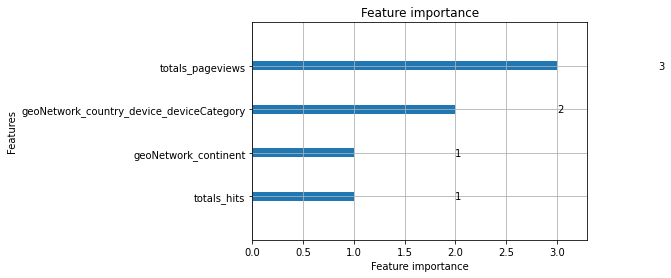

In [394]:
lgb.plot_importance(clf1, importance_type='split');

In [297]:
importances1_df = pd.DataFrame()
importances1_df['feature'] = X_train.columns
importances1_df['gain'] = clf1.booster_.feature_importance(importance_type='gain')
importances1_df['split'] = clf1.booster_.feature_importance(importance_type='split')

In [298]:
importances1_df['gain_log'] = np.log1p(importances1_df['gain'])
importances1_df['split_log'] = np.log1p(importances1_df['split'])

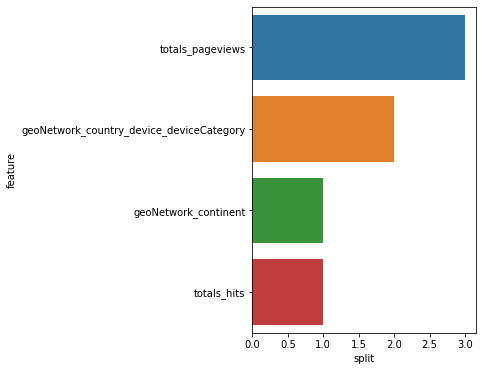

In [414]:
plt.figure(figsize=(4, 6))
sns.barplot(x='split', y='feature', data=importances1_df.sort_values('split', ascending=False).head(4));

# save the plot as a PNG file
plt.savefig('feature_importance_split_lgbm_opt_only4.png', dpi=300, bbox_inches='tight')

# show the plot
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

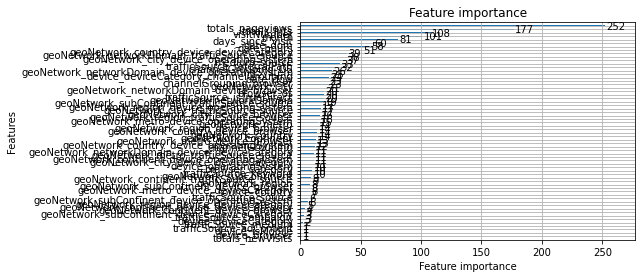

In [304]:
lgb.plot_importance(clf)

In [310]:
def blind_zero_pred(df):
    return np.zeros(df.shape[0],dtype=int)

In [396]:
def blind_ones_pred(df):
    return np.ones(df.shape[0],dtype=int)

In [319]:
fbeta_score(y_test, blind_zero_pred(X_test), beta=2)

0.0

In [397]:
accuracy_score(y_test, blind_ones_pred(X_test))

0.012956610677665077

In [398]:
recall_score(y_test, blind_ones_pred(X_test))

1.0

In [399]:
accuracy_score(y_test, blind_ones_pred(X_test))

0.012956610677665077

In [400]:
fbeta_score(y_test, blind_ones_pred(X_test), beta=2)

0.061591010415533075